In [1]:
!pip install pytorch-pretrained-bert

In [2]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

import matplotlib.pyplot as plt
%matplotlib inline

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
import json
import pandas as pd
from os.path import join, exists
from collections import OrderedDict

def load_json(filename: str,filepath: str = '',date_time_tag: str = '',ext: str = ".json",
              show_path: bool = False) -> OrderedDict:
    file_loc = join(filepath,date_time_tag + filename + ext)
    if show_path:
        print("Reading JSON file: [{}]".format(file_loc))
    if exists(join(filepath,date_time_tag + filename + ext)):
        try:
            with open(file_loc, encoding="utf-8") as file:
                json_dict = json.load(file)
                json_dict = OrderedDict(json_dict)
                # json_dict = OrderedDict(json.load(file))
            file.close()
            return json_dict
        except Exception as e:
            print("Could not open file as JSON: [{}]. \n Reason:[{}]".format(file_loc,e))
            with open(file_loc, encoding="utf-8") as file:
                json_dict = str(file)
                json_dict = json.loads(json_dict)
                # json_dict = OrderedDict(json_dict)
            return json_dict
    else:
        print("File does not exist at: [{}]".format(file_loc))
        return False

def json2df(filename = "smerp_labeled_validation",dataset_dir=""):
    catid2cattxt_map = load_json(filename=filename,filepath=dataset_dir)
    idxs, tweets, labels = [], [], []
    for idx in catid2cattxt_map.keys():
        idxs.append(idx)
        tweets.append(catid2cattxt_map[idx]["parsed_tweet"])
        labels.append(catid2cattxt_map[idx]["classes"])

    df = pd.DataFrame.from_dict({"idx"    :idxs,
                                    "tweets"   :tweets,
                                    "labels":labels})
    df = df[~df['tweets'].isna()]
    df.to_csv(path_or_buf=join(dataset_dir,filename + "_df.csv"))
    print("Data shape = {} ".format(df.shape))
    return df

df = json2df()
df.head()

Data shape = (566, 3) 


,idx,tweets,labels
0,768744566203768832,earthquake italy 267 dead hundreds injured,[2]
1,768822900812046340,dlusvideonews montepulciano damages earthquake...,[2]
2,768848577225428992,italy quake young girl found alive rubble leas...,"[0, 3]"
3,769138472636469248,new post national disaster italy quake death t...,[2]
4,769113679073800193,number dead italy quake climbs first funerals ...,[2]


In [4]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
spacy_en = spacy.load("en_core_web_sm")
# Isnt required here as already cleaned dataset

In [5]:
## Function to tokenize input text for cleaning
def tokenizer_spacy(input_text: str,remove_stopwords=False):
    input_text = spacy_en(input_text)
    tokens = []
    for token in input_text:
        if remove_stopwords and token.text in STOP_WORDS:
            continue
        tokens.append(token.text)
    return tokens

In [6]:
## Cleaning function
import re
# all_stops = set(STOP_WORDS) | set(string.punctuation)
def clean_txt(txt):
    txt = re.sub('[^A-Za-z0-9 ]+', '', txt)
    txt = [token for token in tokenizer_spacy(txt) if token.lower() not in STOP_WORDS]
    txt = " ".join(txt)
    return txt

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [7]:
## Apply cleaning function to input data
data["txts"] = data["txts"].apply(clean_txt)
logger.debug(type(data["txts"].iloc[0]))
logger.debug(data["txts"].iloc[0])
logger.debug(data.head())
data["txts"].str.replace('\s{2,}', ' ')  ## Replaces multiple spaces to single
data.to_csv(datafile,index=None,header=True)
data.head()

0             earthquake italy 267 dead hundreds injured
1      dlusvideonews montepulciano damages earthquake...
2      italy quake young girl found alive rubble 240 ...
3      new post national disaster italy quake death t...
4      number dead italy quake climbs funerals held i...
                             ...                        
561    urlurl canadian dead italys earthquake canadia...
562    dead toll rises italy earthquake 120 reported ...
563    mayor amatrice italy says quakedamaged city ne...
564    usgs estimated significant casualties likely e...
565    death toll italyearthquake 250 365 people inju...
Name: tweets, Length: 566, dtype: object

In [8]:
def add_spl_tokens(tweets):
    return "[CLS] " + tweets + " [SEP]"

In [9]:
## Divide data to train, val and test
train_size, val_size = 0.7, 0.1
train_df = data[0:int(data.shape[0] * train_size)]
print(train_df.shape)
val_df = data[int(data.shape[0] * train_size):int(data.shape[0] * (train_size + val_size))]
print(val_df.shape)
test_df = data[int(data.shape[0] * (train_size + val_size)):int(data.shape[0])]
print(test_df.shape)

train_df.to_csv('data/XC_GCN_BERT_train.csv', sep=',', index=False, header=True)
val_df.to_csv('data/XC_GCN_BERT_val.csv', sep=',', index=False, header=True)
test_df.to_csv('data/XC_GCN_BERT_test.csv', sep=',', index=False, header=True)

(113, 3)
(566, 3)
(453, 3)


In [40]:
## Prepare input text for BERT and truncate long text larger than 512 tokens
max_seq_length = 512
txts_tokens = []
txts_segment_ids = []
indexed_tokens = []
i=0
max_len = 0
max_tokens = []
for txt in train_df["txts"]:
    txt_cleaned = add_spl_tokens(txt)
    txt_tokens = BERT_tokenizer.tokenize(add_spl_tokens(txt))
    if len(txt_tokens) > max_seq_length:
        i+=1
        if len(txt_tokens) > max_len: 
            max_len = len(txt_tokens)
            max_tokens = txt_tokens
        txt_tokens = txt_tokens[:max_seq_length]
    txts_tokens.append(txt_tokens)
    txt_segment_ids = [1] * len(txt_tokens)
    txts_segment_ids.append(txt_segment_ids)
    txt_tokens_ids = BERT_tokenizer.convert_tokens_to_ids(txt_tokens)
    indexed_tokens.append(txt_tokens_ids)
    
    padding = [0] * (max_seq_length - len(txt_tokens_ids))
    txt_tokens_ids += padding
#     input_mask += padding
    txt_segment_ids += padding

    assert len(txt_tokens_ids) == max_seq_length
#     assert len(input_mask) == max_seq_length
    assert len(txt_segment_ids) == max_seq_length

In [41]:
print("Documnets with more than {} tokens:[{}]".format(max_seq_length,i))
print("max_len: [{}]".format(max_len))
print("max_tokens: [{}]".format(max_tokens))

Documnets with more than 64 tokens:[0]
max_len: [0]
max_tokens: [[]]


In [12]:
for tup in zip(txts_tokens[0], indexed_tokens[0]):
    print(tup)

('[CLS]', 101)
('updated', 7172)
('italy', 3304)
('earthquake', 8372)
('250', 5539)
('fatalities', 20871)
('360', 9475)
('injured', 5229)
('sis', 24761)
('##mo', 5302)
('te', 8915)
('##mb', 14905)
('##lor', 10626)
('cnn', 13229)
('ur', 24471)
('##lu', 7630)
('##rl', 12190)
('[SEP]', 102)


In [42]:
tokens_tensor = torch.tensor([indexed_tokens[0]])
segments_tensors = torch.tensor([txts_segment_ids[0]])
print(tokens_tensor)
print(segments_tensors)

tensor([[  101,  7172,  3304,  8372,  5539, 20871,  9475,  5229, 24761,  5302,
          8915, 14905, 10626, 13229, 24471,  7630, 12190,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [14]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=

In [63]:
all_encoded_layers = []
for txt_tokens_ids,txt_segment_ids in zip(indexed_tokens,txts_segment_ids):
    tokens_tensor = torch.tensor([txt_tokens_ids])
    segments_tensors = torch.tensor([txt_segment_ids])
#     logger.info(tokens_tensor)
#     logger.info(segments_tensors)
#     logger.info(tokens_tensor.shape, segments_tensors.shape)
    assert tokens_tensor.shape == segments_tensors.shape, "shape does not match"
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)
        all_encoded_layers.append(encoded_layers)
print("Number of documents: [{}]".format(len(all_encoded_layers)))
layer_i = 0

print("Number of layers: [{}]".format(len(all_encoded_layers[layer_i])))
batch_i = 0

print("Number of tokens: [{}]".format(len(all_encoded_layers[layer_i][batch_i])))
token_i = 0

print("Number of tokens: [{}]".format(len(all_encoded_layers[layer_i][batch_i][token_i]),"\n"))

Number of layers: [453]
Number of batches: [12]
Number of tokens: [1]
Number of hidden units: [64]


In [61]:
print(len(encoded_layers))


12


In [45]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

torch.Size([64, 768])
tensor([ 5.1236e-01, -4.9300e-01,  6.2954e-01, -1.0269e-02,  1.2519e+00,
         6.0471e-01,  2.3423e-01,  1.9247e-01,  4.4352e-01,  2.5995e-01,
        -3.8186e-02,  5.9640e-01,  3.4475e-01,  1.1276e-01, -1.6591e+00,
         4.9349e-01, -1.0163e+00,  2.5172e-01, -7.5355e-01, -4.0591e-01,
         1.5207e+00, -2.0056e-01,  4.8248e-01,  2.6045e+00, -4.2402e-02,
         1.4331e-01,  1.5549e+00, -2.4001e-01,  3.8056e-01, -1.0928e+00,
         5.6604e-02, -7.3802e-01,  1.2466e+00, -1.7257e+00, -8.9991e-01,
        -1.9250e+00, -2.9613e+00, -7.4195e-01,  1.0127e+00,  9.2177e-02,
        -6.7863e-01,  4.6158e-01, -6.9841e-01,  4.0295e-01, -1.7117e-01,
         4.6207e-01,  1.2775e+00, -1.6717e+00,  6.3274e-01, -8.7934e-01,
        -2.8565e-01, -1.4899e-01,  1.6652e+00, -4.2199e-01,  1.2057e+00,
        -1.2272e+00,  3.0324e-01, -5.9583e-01,  6.0381e-01,  3.0766e-01,
         5.4924e-01, -8.3224e-01,  1.2049e+00, -1.4595e+00, -1.5858e+00,
        -7.3449e-01, -4.3038e

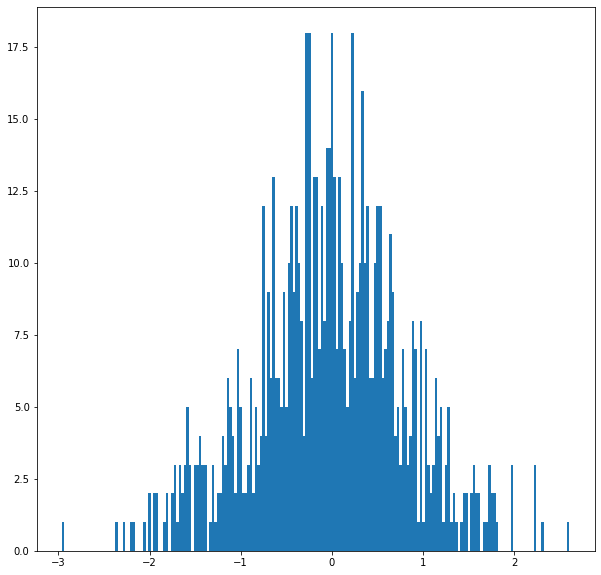

In [46]:
token_i = 6
batch_i = 0
layer_i = 6

print(encoded_layers[layer_i][0].shape)

vec = encoded_layers[layer_i][batch_i][token_i]
print(vec)

plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [62]:
# print(len(txts_tokens[1]))
# print(txts_tokens[1])
# print(len(txts_tokens))
# all_embeddings = []
# for batch_i in range(0, len(txts_tokens)):
#     for txt_tokens in txts_tokens:
#         token_embeddings = []

#     #     print(len(txt_tokens))
#         for token_i in range(len(txt_tokens)):
#             hidden_layers = [] 
#             for layer_i in range(len(encoded_layers)):
#     #             print(layer_i,batch_i,token_i)
#     #             print(encoded_layers[layer_i][batch_i].shape)
#                 vec = encoded_layers[layer_i][batch_i][token_i]    
#                 hidden_layers.append(vec)
#             token_embeddings.append(hidden_layers)
#         all_embeddings.append(token_embeddings)

# # Sanity check the dimensions:
# print ("Number of tokens in sequence:", len(token_embeddings))
# print ("Number of layers per token:", len(token_embeddings[0]))
# print ("Number of total embeddings:", len(all_embeddings))

19
['[CLS]', 'survival', 'wild', 'survival', 'tool', 'aid', 'touch', 'emergency', 'bag', 'earthquake', 'aid', 'bag', 'ur', '##lu', '##rl', 'ur', '##lu', '##rl', '[SEP]']
453


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [51]:
# token_vecs_cat = []
# token_vecs_sum = []

# for token in token_embeddings:
#     cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), 0)
#     token_vecs_cat.append(cat_vec)
#     sum_vec = torch.sum(torch.stack(token)[-4:], 0)
#     token_vecs_sum.append(sum_vec)

# print('Concatenated vector shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))
# print('Sum vector shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Concatenated vector shape is: 2 x 3072
Sum vector shape is: 2 x 768


In [56]:
## Generate sentence lavel vector by averaging the second to last hidden layer of each token producing a single 768 length vector.
all_sentences_embedding = []

for batch_i in range(len(txts_tokens)):
    all_sentences_embedding.append(torch.mean(all_encoded_layers[batch_i][11], 1))

print(len(all_sentences_embedding))

print ("Count of sentence embeddings found:",len(all_sentences_embedding))
print ("Single sentence embedding vector of shape:",all_sentences_embedding[0].shape)

tensor([[[-0.2284, -0.0532,  0.4066,  ...,  0.0106,  0.1508, -0.3040],
         [-0.0853, -0.4222,  0.6365,  ..., -0.5717,  0.1021, -0.3731],
         [ 0.1465, -0.3322,  0.7312,  ..., -0.1375,  0.1943,  0.3347],
         ...,
         [ 0.0594, -0.2842,  0.9968,  ..., -0.5556,  0.0894, -0.6480],
         [ 0.0696, -0.2859,  1.0168,  ..., -0.5726,  0.1498, -0.6146],
         [ 0.0638, -0.2205,  0.9603,  ..., -0.5755,  0.1049, -0.6666]]])
torch.Size([1, 64, 768])
Our final sentence embedding vector of shape:


(None, torch.Size([1, 768]))

In [21]:
# def knn_lbl_majority(test_features,train_features,train_labels,k=5):

#     from sklearn.neighbors import KNeighborsClassifier

#     NN = KNeighborsClassifier(n_neighbors=k)
#     NN.fit(train_features,train_labels)
#     test_labels = NN.predict(test_features)
#     ## To get probabilities: test_labels_probas = NN.predict_proba(test_features)
#     return test_labels

In [22]:
def neighrest_neighbors(test_features,train_features,n,k=2):
    from sklearn.neighbors import NearestNeighbors

    NN = NearestNeighbors(n_neighbors=k)
    NN.fit(train_features)
    closest_neighbors_from_train = NN.kneighbors(test_features,
    return_distance=False)
    return closest_neighbors_from_train[0:n]

In [25]:
import numpy as np
test_features = test_df_bert['tweets']
train_features = 
train_labels = txts_tokens['labels']
n=2
n_idxs = neighrest_neighbors(test_features, train_features, n)
count = np.zeros(4)
#n is for precision at k
print(test_features)
print(train_features)
print(train_labels)
for ii in n_idxs:
    count = np.zeros(4)
    for l in range(0,n):
        for i in n_idxs[l]:
            for j in train_labels[i]:
                count[j] = count[j] + 1

    
    print(np.argsort(count)[4-n:])
        
    


# print(test_labels[0:2])

TypeError: list indices must be integers or slices, not str

In [ ]:
1